## Imports

In [2]:
# If any of the library below is not present, uncomment below line.
# !pip install imbalanced-learn

In [ ]:
# Libraries Imports
import pandas as pd
import numpy as np

#SMOTE libraries import
from imblearn.over_sampling import SMOTE

# Ignoring the warnings
import warnings
warnings.filterwarnings("ignore")

#Model imports
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

#Model related imports
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline

#Graphical imports
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

## Data selection

In [5]:
filename = "P12_fake_job_postings.csv"

dataset = pd.read_csv(filename)
dataset_no_id = dataset.drop(columns=['job_id'])
dataset_no_id

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


## Data visualization

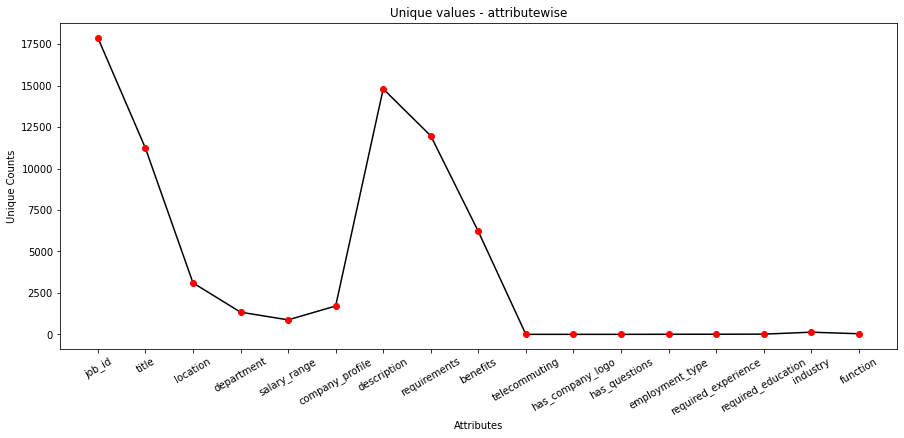

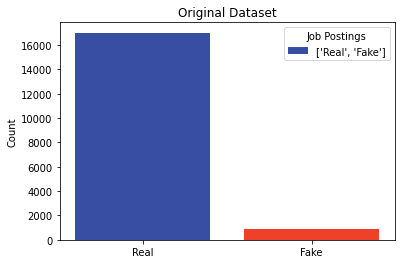

In [6]:
### intial_data_visualization(dataset):
# Getting unique values count
dataset_no_label = dataset.copy().drop(columns=['fraudulent'])
unique_vals = [dataset_no_label[col].unique().size for col in dataset_no_label.columns]
f_unique, ax_unique = plt.subplots(1,1,figsize=(15,6))
ax_unique.plot(list(dataset_no_label.columns), unique_vals, "k-")
ax_unique.plot(list(dataset_no_label.columns), unique_vals, "ro")
ax_unique.set_title("Unique values - attributewise")
ax_unique.set_xlabel("Attributes")
ax_unique.set_ylabel("Unique Counts")
ax_unique.set_xticklabels(list(dataset_no_label.columns), rotation=30)

def visualize_data_class(dataset, title):
    real_vals = (dataset["fraudulent"]==0).sum()
    fake_vals = (dataset["fraudulent"]==1).sum()
    labels = ["Real", "Fake"]
    vals = [real_vals, fake_vals]
    bar_colors=["#374EA2", "#EF4129"]
    f_fraud, ax_fraud = plt.subplots(1,1)
    ax_fraud.bar(labels, vals, label=labels, color=bar_colors)
    ax_fraud.set_ylabel("Count")
    ax_fraud.legend(title="Job Postings")
    ax_fraud.set_title(title)
    plt.show()

visualize_data_class(dataset, "Original Dataset")

## Data Preprocessing


Correlation Matrix:
                         title  location  department  salary_range  \
title                1.000000  0.108996    0.148319      0.119633   
location             0.108996  1.000000    0.036406      0.050909   
department           0.148319  0.036406    1.000000      0.069141   
salary_range         0.119633  0.050909    0.069141      1.000000   
company_profile      0.220294  0.075544    0.116334      0.105350   
employment_type     -0.076230  0.120573   -0.028196     -0.073005   
required_experience -0.026002 -0.019332    0.022856      0.112290   
required_education  -0.000442  0.069238    0.050986      0.103305   
industry             0.070233  0.046482    0.059183      0.091731   
function             0.043842 -0.037178    0.070448      0.071457   
fraudulent           0.052733  0.079086    0.035257      0.057828   

                     company_profile  employment_type  required_experience  \
title                       0.220294        -0.076230            -0.026

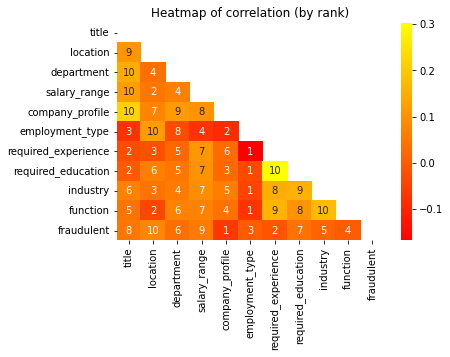

In [7]:
# fill null, not applicable and unspecified values with 'No Info'
dataset.fillna('No Info', inplace=True)
dataset = dataset.replace(['Not Applicable', 'Unspecified'], 'No Info')

# removing duplicate entries
dup_df = dataset[dataset.duplicated()]
no_dup_df = dataset.drop_duplicates()

# only keeping selected columns
df_selected_cols = no_dup_df[['title', 'location', 'department', 'salary_range' , 'company_profile', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']]
df_ccount = len(df_selected_cols)

# categorical to numerical conversion - https://pandas.pydata.org/docs/reference/api/pandas.factorize.html
category_cols = df_selected_cols.select_dtypes(['object']).columns
df_selected_cols[category_cols] = df_selected_cols[category_cols].apply(lambda x: pd.factorize(x)[0]) # codes, uniques = pd.factorize(cat)

def heatmap_correlation(df, corr_flag=False):
    # using heatmap to see correlation between data points
    correlation_matrix = df.corr()
    if corr_flag: print('\nCorrelation Matrix:\n', correlation_matrix)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    f_heatmap, ax_heatmap = plt.subplots(1,1)
    i = sns.heatmap(correlation_matrix, mask=mask, annot=correlation_matrix.rank(axis="columns"), cmap="autumn", cbar=ax_heatmap)
    ax_heatmap.set_title("Heatmap of correlation (by rank)")
heatmap_correlation(df_selected_cols, corr_flag=True)

features = df_selected_cols.drop(['fraudulent'],axis=1).columns
label = 'fraudulent'

[(11231, 'title'), (3106, 'location'), (1338, 'department'), (875, 'salary_range'), (1710, 'company_profile'), (6, 'employment_type'), (7, 'required_experience'), (13, 'required_education'), (132, 'industry'), (38, 'function'), (2, 'fraudulent')]
Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent'],
      dtype='object')


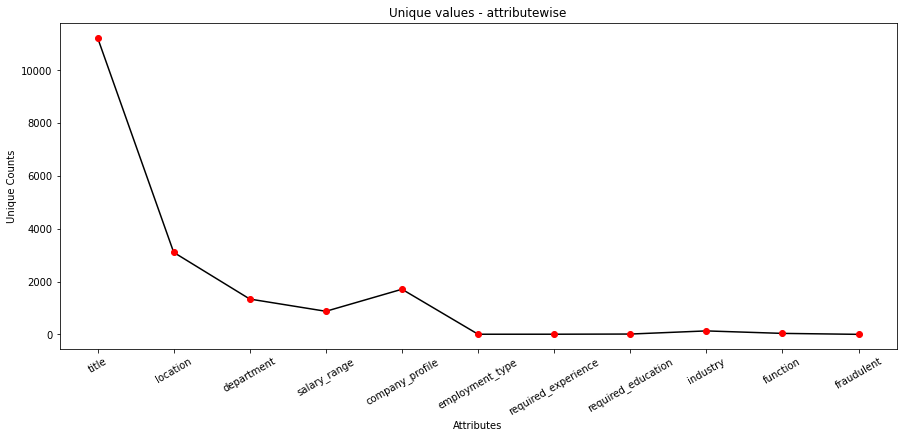

In [8]:
def vis_cols():
    dbf = df_selected_cols
    unq_vals = [dbf[col].unique().size for col in dbf.columns]
    print([(unq_vals[i],dbf.columns[i]) for i in range(len(unq_vals))])
    print(dbf.columns)
    f_unq, ax_unq = plt.subplots(1,1,figsize=(15,6))
    ax_unq.plot(list(dbf.columns), unq_vals, "k-")
    ax_unq.plot(list(dbf.columns), unq_vals, "ro")
    ax_unq.set_title("Unique values - attributewise")
    ax_unq.set_xlabel("Attributes")
    ax_unq.set_ylabel("Unique Counts")
    ax_unq.set_xticklabels(list(dbf.columns), rotation=30)
vis_cols()

## Model

### Data Split

In [9]:
# train data - 75% / 80%
# test data - 25% / 20%

X = df_selected_cols.drop(['fraudulent'],axis=1)
Y = df_selected_cols["fraudulent"]

### splitting(X, Y):
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X, Y, stratify=Y, test_size=0.20, shuffle=True, random_state=8)
X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(X, Y, stratify=Y, test_size=0.25, shuffle=True, random_state=8)

### SMOTE

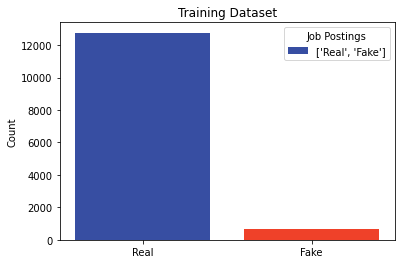

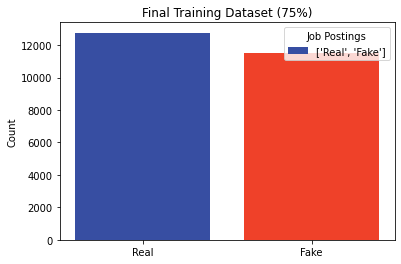

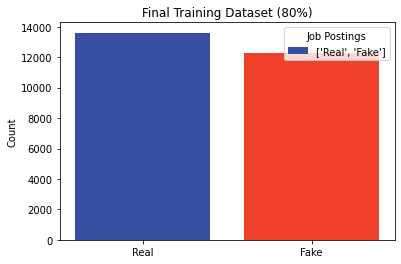

In [10]:
# X = df_selected_cols.drop(['fraudulent'],axis=1)
# y = df_selected_cols["fraudulent"]
df_train_data = pd.concat([X_train_25, y_train_25], axis=1)
visualize_data_class(df_train_data, "Training Dataset")


oversample = SMOTE(sampling_strategy=0.9)
X_train_smoted_25, y_train_smoted_25 = oversample.fit_resample(X_train_25, y_train_25)
df_tv_smoted_25 = pd.concat([X_train_smoted_25, y_train_smoted_25], axis=1)
visualize_data_class(df_tv_smoted_25, "Final Training Dataset (75%)")

X_train_smoted_20, y_train_smoted_20 = oversample.fit_resample(X_train_20, y_train_20)
df_tv_smoted_20 = pd.concat([X_train_smoted_20, y_train_smoted_20], axis=1)
visualize_data_class(df_tv_smoted_20, "Final Training Dataset (80%)")


### Classifiers

In [11]:
def smoted_cv(model, X_train, y_train, text_here="this model"):
    steps = [('over', SMOTE()), ('model', model)]
    pipeline = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)
    print("Recall for", text_here, ":", np.mean(scores))

In [12]:
def evaluate_data(X_train, y_train):
    print("\n--- KNN Classifier ---")
    n = [1, 3, 5, 10]
    for k in n:
        smoted_cv(KNeighborsClassifier(n_neighbors=k), X_train, y_train, text_here=(str(k)+"NN"))

    print("\n--- Decision Tree Classifier ---")
    smoted_cv(DecisionTreeClassifier(), X_train, y_train, text_here="Decision Tree")

    print("\n--- Naive Bayes Classifier ---")
    smoted_cv(GaussianNB(), X_train, y_train, text_here="Naive Bayes")

    print("\n--- Logistic Regression Classifier ---")
    smoted_cv(LogisticRegression(random_state=1), X_train, y_train, text_here="Logistic Regression")

In [13]:
evaluate_data(X_train_25, y_train_25)


--- KNN Classifier ---
Recall for 1NN : 0.6132371794871797
Recall for 3NN : 0.653846153846154
Recall for 5NN : 0.6702724358974361
Recall for 10NN : 0.7015544871794874

--- Decision Tree Classifier ---
Recall for Decision Tree : 0.7282371794871796

--- Naive Bayes Classifier ---
Recall for Naive Bayes : 0.608092948717949

--- Logistic Regression Classifier ---
Recall for Logistic Regression : 0.5958253205128207


In [14]:
evaluate_data(X_train_20, y_train_20)


--- KNN Classifier ---
Recall for 1NN : 0.5960110420979985
Recall for 3NN : 0.6373706004140787
Recall for 5NN : 0.6618771566597654
Recall for 10NN : 0.6878881987577639

--- Decision Tree Classifier ---
Recall for Decision Tree : 0.7277639751552797

--- Naive Bayes Classifier ---
Recall for Naive Bayes : 0.6021601104209798

--- Logistic Regression Classifier ---
Recall for Logistic Regression : 0.5752726017943409


## Inference

In our example, Positive label refers to the job being fraud and negative label corresponds to the job being a genuine posting. We'll be preferring Recall measure for the below reason:

Consider a False positive scenario

Consider a False negative scenario

Explain False negative > False Positive

Therefore, for our model evaluations we'll be preferring Recall measure

In [15]:
def m_predict(model, x_data, y_data, typ="test"):
    y_pred = model.predict(x_data)
    accuracy = metrics.accuracy_score(y_data, y_pred)
    recall = metrics.recall_score(y_data, y_pred)
    precision = metrics.precision_score(y_data, y_pred)
    mets = {'Accuracy': accuracy, 'Recall': recall, 'Precision': precision}
    return mets

In [16]:
### decision_tree_classifier(data):
print("\n--- Final Classifier - Decision Tree ---")
all_metri_tv_smoted_25 = pd.DataFrame()
model_tv_smoted_25 = DecisionTreeClassifier().fit(X_train_smoted_25,y_train_smoted_25)

mets_t_smoted_25 = m_predict(model_tv_smoted_25, X_test_25, y_test_25, typ="test")
metri_t_smoted_25 = pd.DataFrame(data=mets_t_smoted_25, index=["Test"])
all_metri_tv_smoted_25 = pd.concat([all_metri_tv_smoted_25, metri_t_smoted_25])

print("\n:: Test Dataset (25%) - with Decision Tree ::")
print(tabulate.tabulate(all_metri_tv_smoted_25, headers='keys', tablefmt="fancy_grid"))

all_metri_tv_smoted_20 = pd.DataFrame()
model_tv_smoted_20 = DecisionTreeClassifier().fit(X_train_smoted_20,y_train_smoted_20)

mets_t_smoted_20 = m_predict(model_tv_smoted_20, X_test_20, y_test_20, typ="test")
metri_t_smoted_20 = pd.DataFrame(data=mets_t_smoted_20, index=["Test"])
all_metri_tv_smoted_20 = pd.concat([all_metri_tv_smoted_20, metri_t_smoted_20])

print("\n:: Test Dataset (20%) - with Decision Tree ::")
print(tabulate.tabulate(all_metri_tv_smoted_20, headers='keys', tablefmt="fancy_grid"))


--- Final Classifier - Decision Tree ---

:: Test Dataset (25%) - with Decision Tree ::
╒══════╤════════════╤══════════╤═════════════╕
│      │   Accuracy │   Recall │   Precision │
╞══════╪════════════╪══════════╪═════════════╡
│ Test │   0.945861 │ 0.718894 │    0.462908 │
╘══════╧════════════╧══════════╧═════════════╛

:: Test Dataset (20%) - with Decision Tree ::
╒══════╤════════════╤══════════╤═════════════╕
│      │   Accuracy │   Recall │   Precision │
╞══════╪════════════╪══════════╪═════════════╡
│ Test │   0.938479 │ 0.757225 │    0.423948 │
╘══════╧════════════╧══════════╧═════════════╛


## Conclusion